In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import requests
import json
import time
from app import *
import os
from sqlalchemy import inspect
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.ticker as ticker


def object_as_dict(obj):
    return {c.key: getattr(obj, c.key) for c in inspect(obj).mapper.column_attrs}

def object_as_df(results):
    dict_result = []

    for result in results:
        new_row = {
            c.key: getattr(result, c.key) for c in inspect(result).mapper.column_attrs
        }
        dict_result.append(new_row)

    df = pd.DataFrame(dict_result)
    return df

grubby_id = 849473199
grubby_steam = 76561198809738927
open_dota = "https://api.opendota.com/api"
dota_constants = "https://raw.githubusercontent.com/odota/dotaconstants/master/json"
dota_constants_build = (
    "https://raw.githubusercontent.com/odota/dotaconstants/master/build/"
)
raw_data = "data/grubby/matches/MatchDetails"

matches = PlayerMatches().query.all()
dict_result = []
for match in matches:
    if match.lobby_type == 7:
        dict_result.append(object_as_dict(match))
df_playermatches = pd.DataFrame(dict_result)

team_dict = dict(zip(df_playermatches.match_id, df_playermatches.team))
# win = dict(zip(df_playermatches.match_id, df_playermatches.win))

player_matches = MatchPlayers().query.all()
dict_result = []
for player_match in player_matches:
    if player_match.lobby_type == 7:
        dict_result.append(object_as_dict(player_match))
df_matchplayers = pd.DataFrame(dict_result)

allies = []
oppo = []
for result in dict_result:
    if (
        result["team"] == team_dict[result["match_id"]]
        and result["player_id"] != 849473199
    ):
        allies.append(result)
    elif result["player_id"] != 849473199:
        oppo.append(result)

heroes = Heroes().query.all()
temp_df_allies = object_as_df(heroes)
map_df = temp_df_allies[["hero_id", "localized_name"]]
mapping_dict = dict(zip(map_df.hero_id, map_df.localized_name))

df_matchplayers['hero_name'] = df_matchplayers['hero_id'].map(mapping_dict)
df_matchplayers['duration'] = df_matchplayers['duration'].div(60)


df_grubby_matchplayers = df_matchplayers.loc[df_matchplayers["player_id"] == grubby_id]

df_most_played = df_matchplayers[['hero_name', 'player_id']].loc[df_matchplayers['player_id'] == grubby_id].value_counts().sort_values(ascending=False).head(10).reset_index()
most_played = df_most_played['hero_name'].to_list()

grubby_lanes = df_matchplayers.loc[df_matchplayers['player_id'] == grubby_id]
grubby_lanes = grubby_lanes[['match_id','lane_role']]
grubby_lanes = dict(zip(grubby_lanes.match_id, grubby_lanes.lane_role))

df_allies = pd.DataFrame(allies)
df_allies.loc[df_allies["player_id"].isna(), "player_id"] = 0
df_allies["player_id"] = df_allies["player_id"].astype(int)
df_allies["hero_name"] = df_allies["hero_id"].map(mapping_dict)
df_allies['grubby_lane'] = df_allies['match_id'].map(grubby_lanes)
df_allies.loc[df_allies["grubby_lane"] == df_allies['lane_role'], "in_same_lane"] = True
df_allies.loc[df_allies["grubby_lane"] != df_allies['lane_role'], "in_same_lane"] = False

df_oppo = pd.DataFrame(oppo)
df_oppo.loc[df_oppo["player_id"].isna(), "player_id"] = 0
df_oppo["player_id"] = df_oppo["player_id"].astype(int)
df_oppo["hero_name"] = df_oppo["hero_id"].map(mapping_dict)
df_oppo['grubby_lane'] = df_oppo['match_id'].map(grubby_lanes)
df_oppo.loc[df_oppo["grubby_lane"] == df_oppo['lane_role'], "in_same_lane"] = True
df_oppo.loc[df_oppo["grubby_lane"] != df_oppo['lane_role'], "in_same_lane"] = False

networth_timings = NetworthTimings().query.filter_by(minute=10).all()
dict_result = []
for networth in networth_timings:
    dict_result.append(object_as_dict(networth))
df_networth_timings = pd.DataFrame(dict_result)
df_matchplayers = pd.merge(df_matchplayers, df_networth_timings, how='left', on=['match_id', 'player_id'])

In [2]:
df_playermatches[['lobby_type', 'game_mode']].value_counts()
df_matchplayers['gold'].info()

<class 'pandas.core.series.Series'>
Int64Index: 18972 entries, 0 to 18971
Series name: gold
Non-Null Count  Dtype  
--------------  -----  
18943 non-null  float64
dtypes: float64(1)
memory usage: 296.4 KB


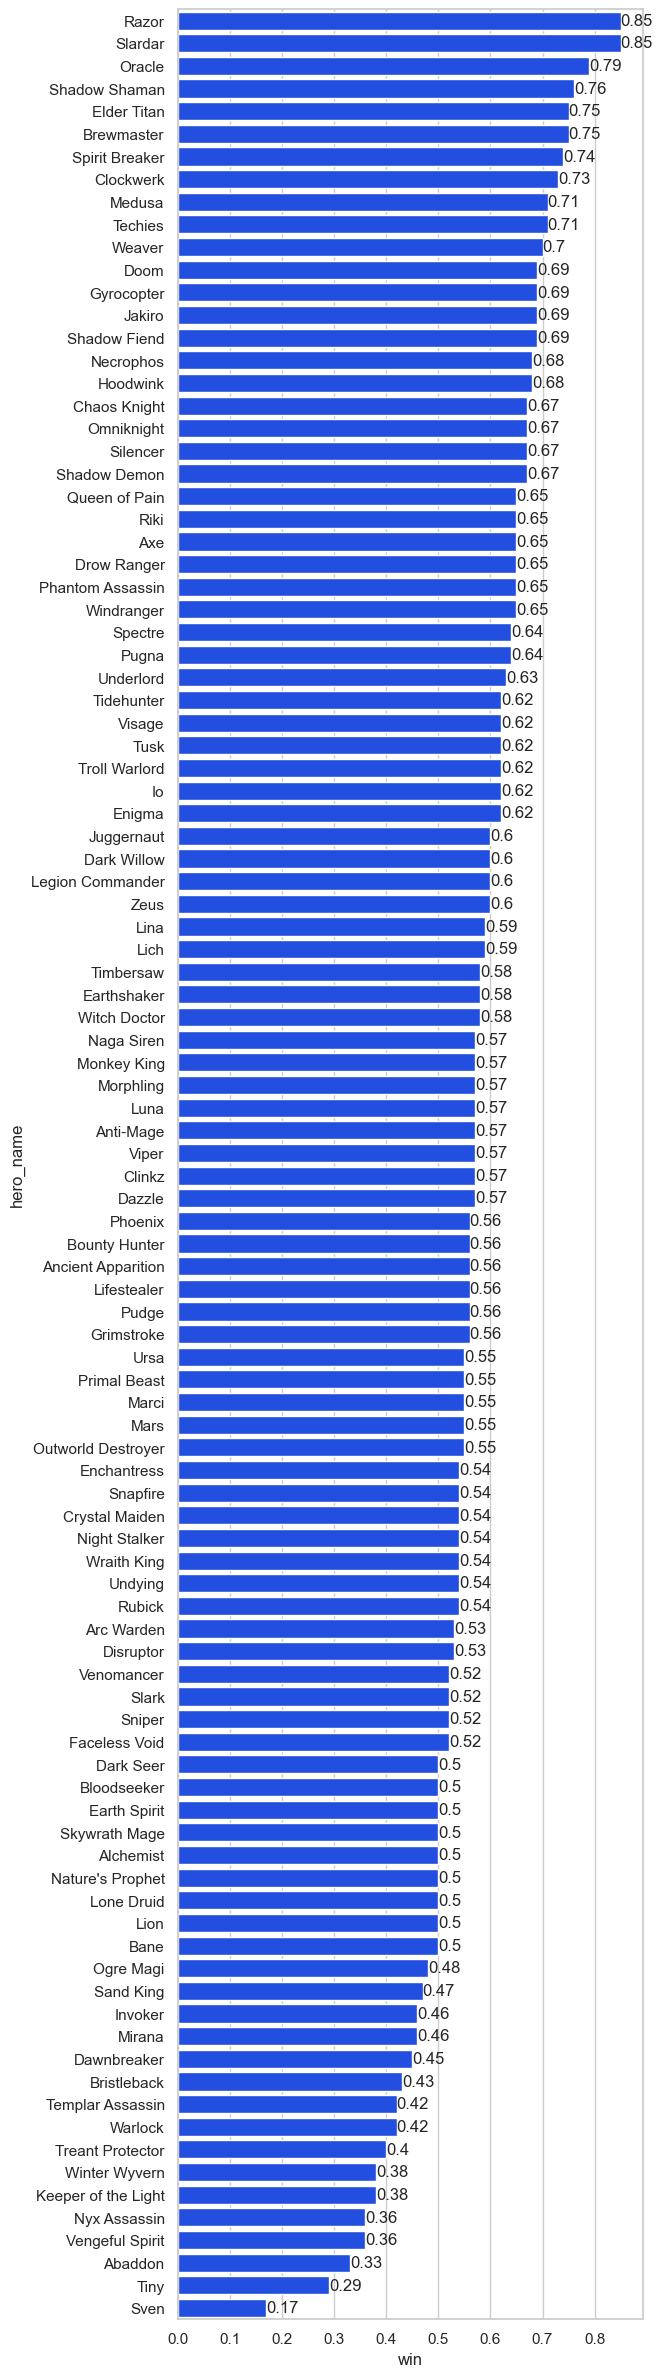

In [3]:
df_ally_wr = df_allies[['hero_name', 'win']].groupby(['hero_name']).mean().sort_values('win', ascending=False).reset_index()
df_ally_count = df_allies['hero_name'].value_counts().reset_index()
df_ally_count.columns = ['hero_name', 'times_played']

df_ally_inlane = df_allies[['hero_name', 'win']].loc[df_allies['in_same_lane'] == True].groupby(['hero_name']).mean().reset_index()
df_ally_inlane.columns = ['hero_name', 'lane_partner_wr']
df_ally_inlane_count = df_allies['hero_name'].loc[df_allies['in_same_lane'] == True].value_counts().reset_index()
df_ally_inlane_count.columns = ['hero_name', 'lane_partner_count']

df_ally_outlane = df_allies[['hero_name', 'win']].loc[df_allies['in_same_lane'] == False].groupby(['hero_name']).mean().reset_index()
df_ally_outlane.columns = ['hero_name', 'nonlane_partner_wr']
df_ally_outlane_count = df_allies['hero_name'].loc[df_allies['in_same_lane'] == False].value_counts().reset_index()
df_ally_outlane_count.columns = ['hero_name', 'nonlane_partner_count']

df_ally_final = df_ally_wr.merge(df_ally_count, on='hero_name')
df_ally_final = df_ally_final.merge(df_ally_inlane, on='hero_name')
df_ally_final = df_ally_final.merge(df_ally_inlane_count, on='hero_name')
df_ally_final = df_ally_final.merge(df_ally_outlane, on='hero_name')
df_ally_final = df_ally_final.merge(df_ally_outlane_count, on='hero_name')
df_ally_final = df_ally_final.round(2)

sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 30))
sns.set_color_codes("bright")
sns.barplot(x="win", y="hero_name", data=df_ally_final, label="Total", color="b")
for i in ax.containers:
    ax.bar_label(i,)

plt.savefig('ally_wr.png', dpi=300, bbox_inches='tight')
df_ally_final.to_csv('visualisations/ally_wr.csv', index=False)

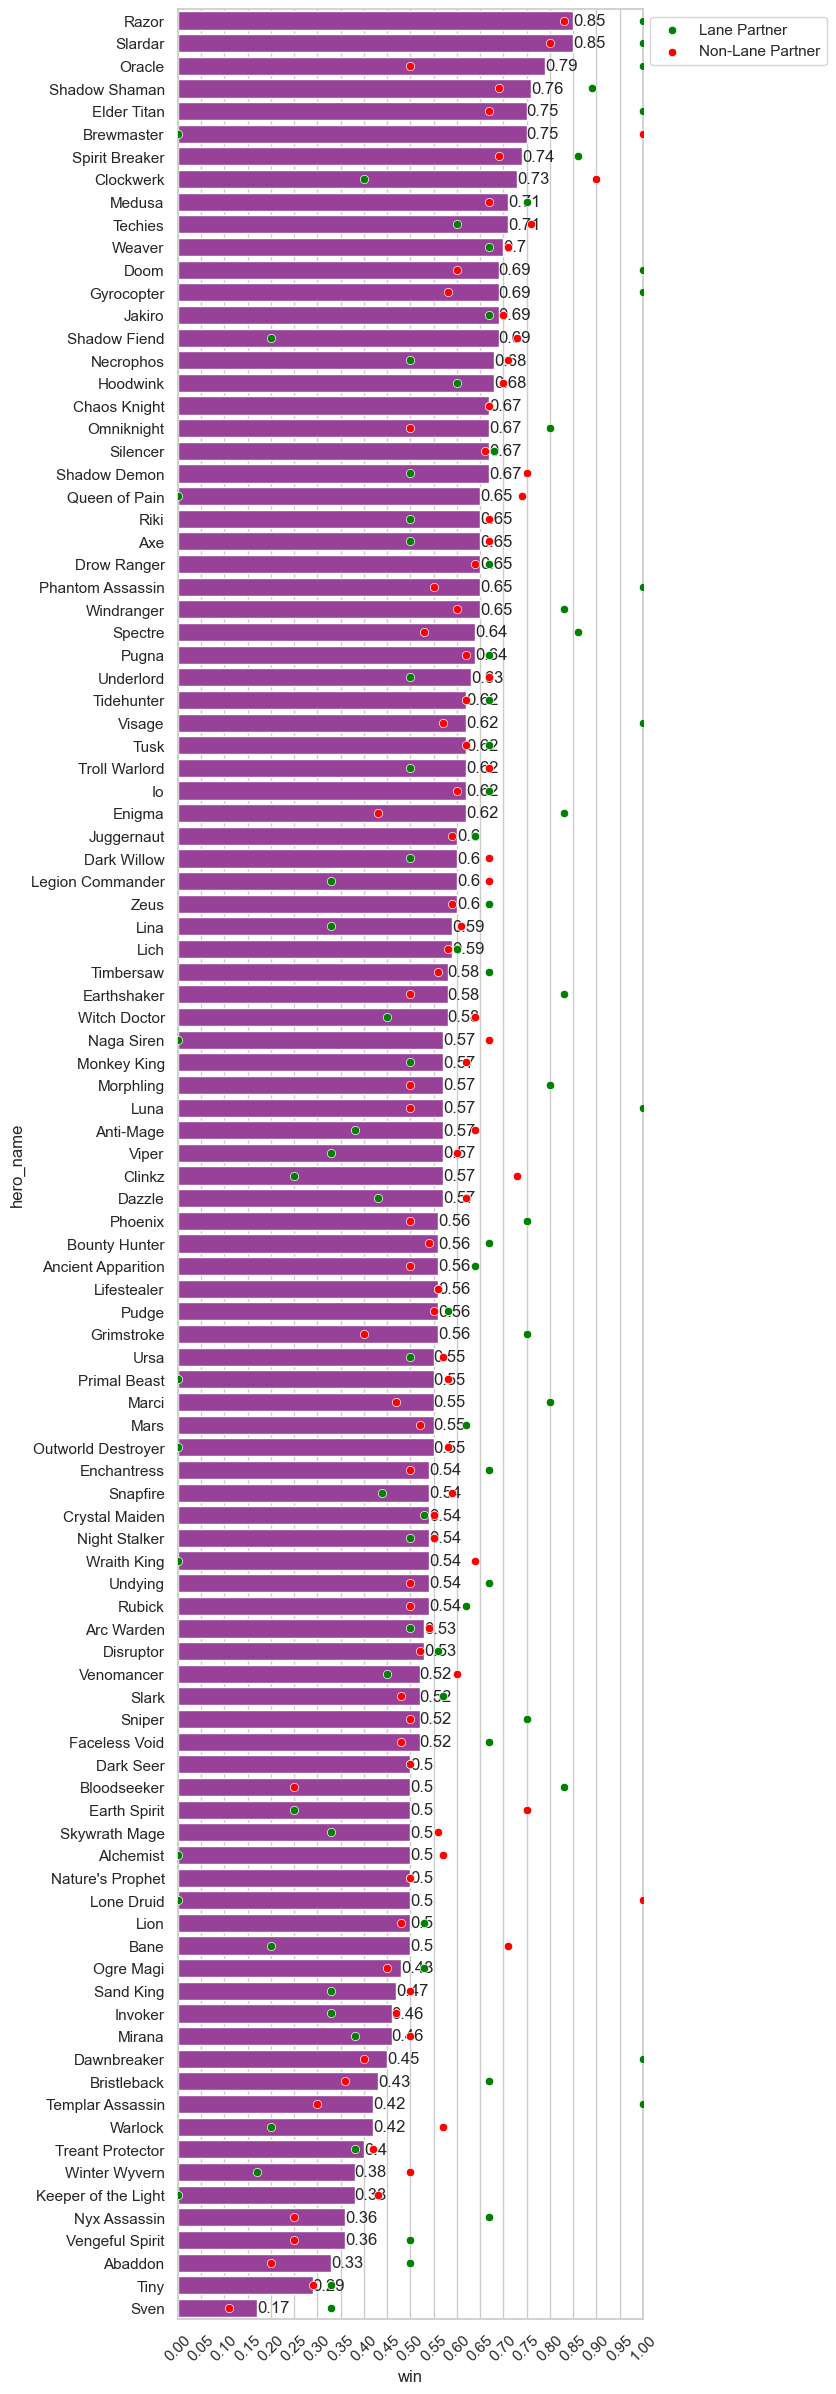

In [4]:
f, ax = plt.subplots(figsize=(6, 30))
ax1 = sns.scatterplot(x="lane_partner_wr",
                    y="hero_name",
                    data=df_ally_final, zorder=100, color='green')
ax2 = sns.scatterplot(x="nonlane_partner_wr",
                    y="hero_name",
                    data=df_ally_final, zorder=100, color='red')
ax3 = sns.barplot(x="win",
                    y="hero_name",
                    data=df_ally_final,
                    color='#a632a8')

plt.legend(labels=['Lane Partner', 'Non-Lane Partner'])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(xlim=(0,1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
plt.xticks(rotation = 45)

for i in ax.containers:
    ax.bar_label(i,)

plt.savefig('visualisations/ally_wr_expanded.png', dpi=300, bbox_inches='tight')
df_ally_final.to_csv('visualisations/ally_wr_expanded.csv', index=False)


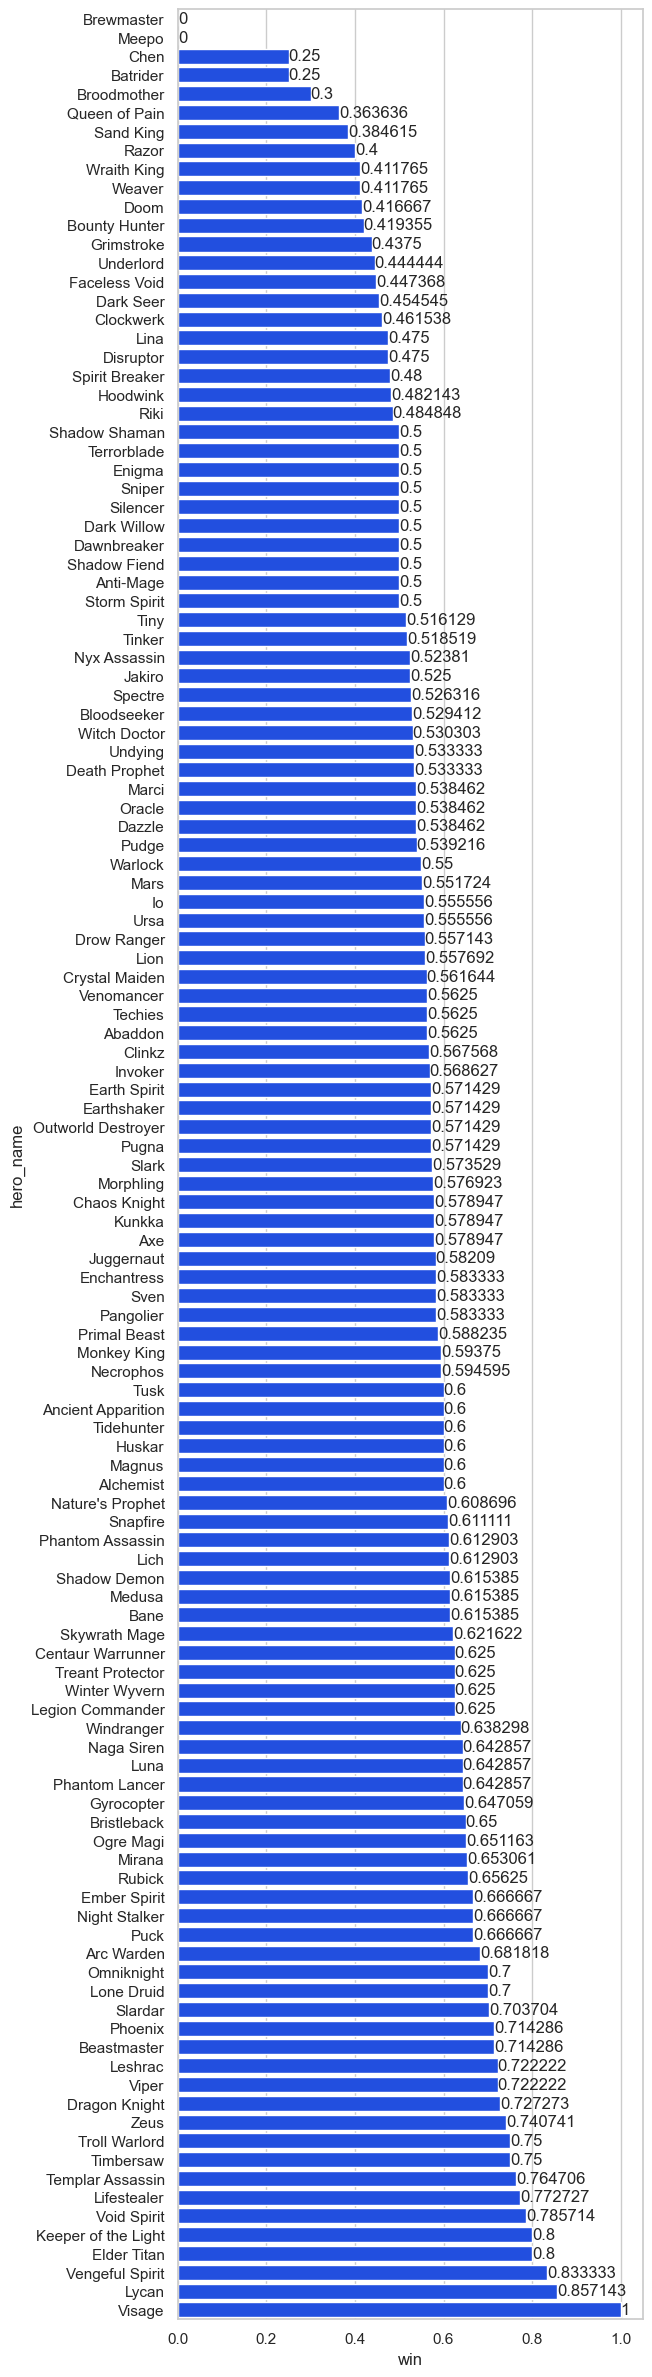

In [5]:
df_oppo_wr = df_oppo[['hero_name', 'win']].groupby(['hero_name']).mean().sort_values('win', ascending=False).reset_index()
df_oppo_count = df_oppo['hero_name'].value_counts().reset_index()
df_oppo_count.columns = ['hero_name', 'times_played']
df_oppo_final = df_oppo_wr.merge(df_oppo_count, on='hero_name')
df_oppo_final['win'] = 1 - df_oppo_final['win']


sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 30))
sns.set_color_codes("bright")
sns.barplot(x="win", y="hero_name", data=df_oppo_final, label="Total", color="b")
for i in ax.containers:
    ax.bar_label(i,)

plt.savefig('oppo_wr.png', dpi=300, bbox_inches='tight')
df_oppo_final.to_csv('oppo_wr.csv', index=False)

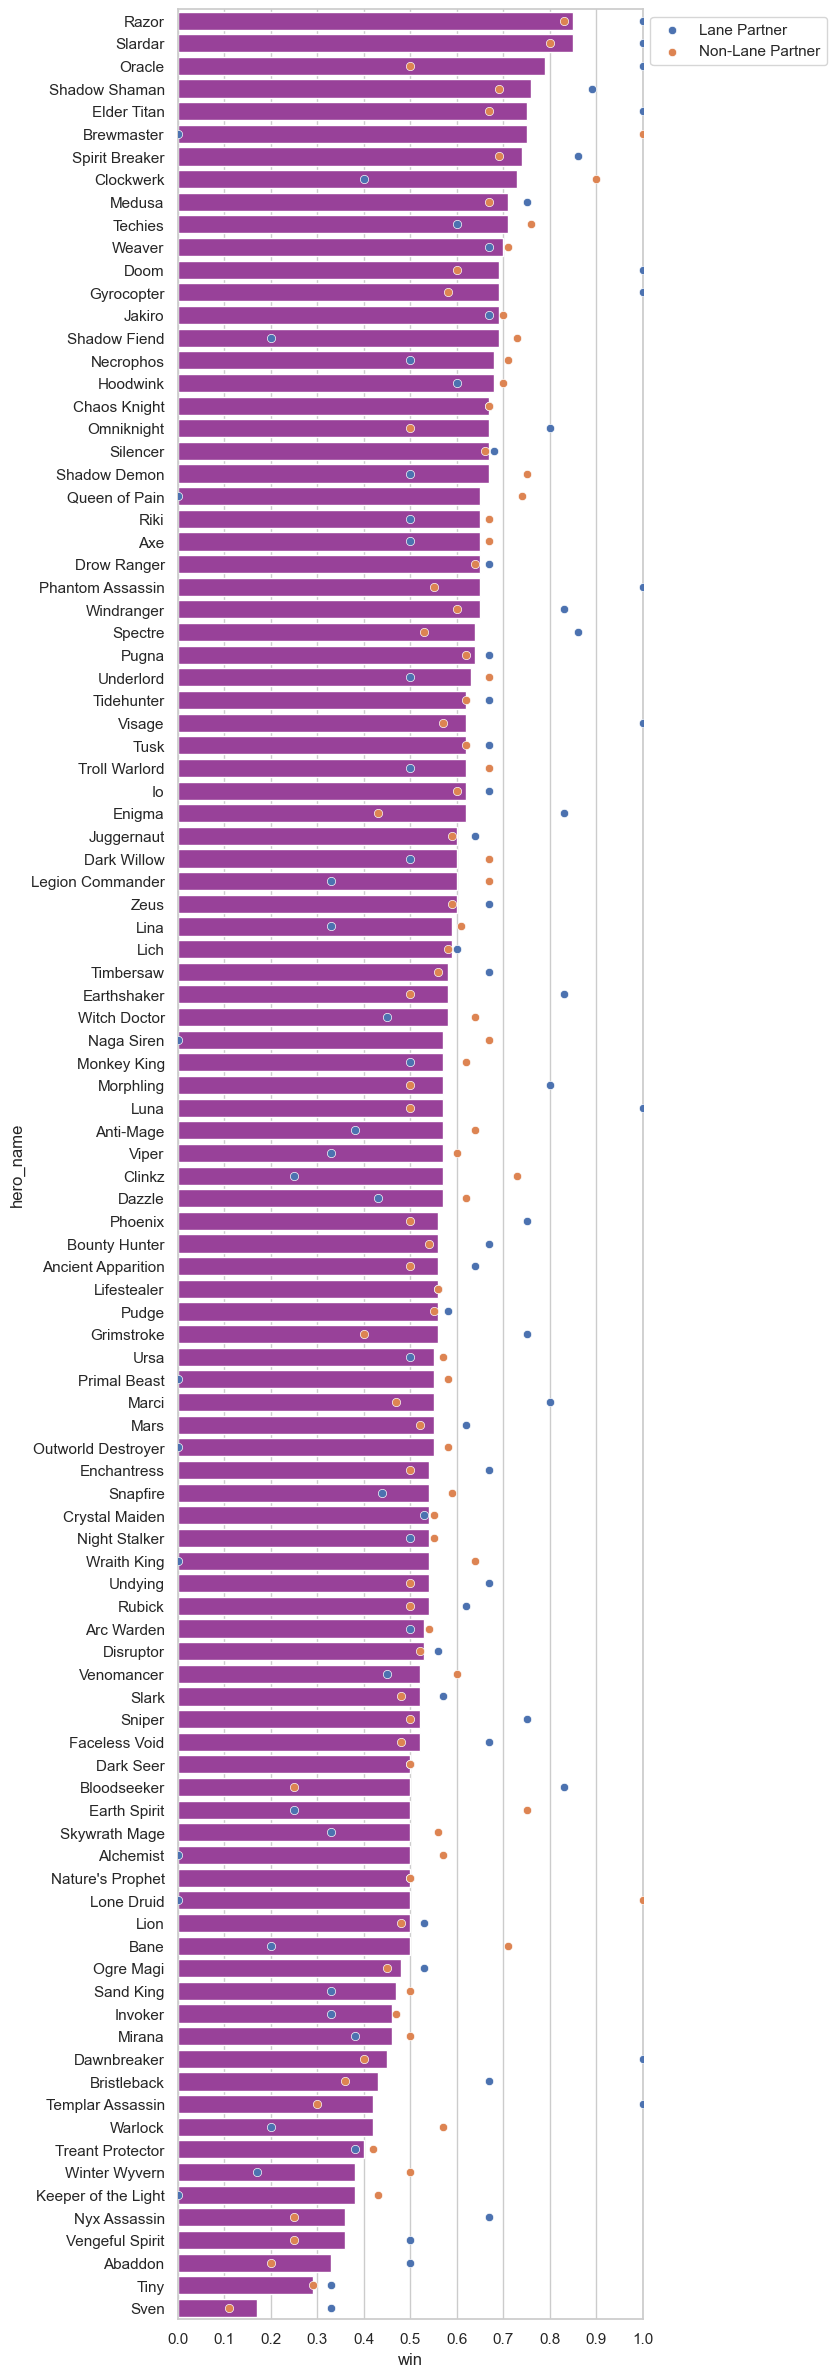

In [6]:
f, ax = plt.subplots(figsize=(6, 30))
ax1 = sns.scatterplot(x="lane_partner_wr",
                    y="hero_name",
                    data=df_ally_final, zorder=100)
ax2 = sns.scatterplot(x="nonlane_partner_wr",
                    y="hero_name",
                    data=df_ally_final, zorder=100)
ax3 = sns.barplot(x="win",
                    y="hero_name",
                    data=df_ally_final,
                    color='#a632a8')

plt.legend(labels=['Lane Partner', 'Non-Lane Partner'])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(xlim=(0,1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))

plt.savefig('visualisations/ally_wr_expanded.png', dpi=300, bbox_inches='tight')
df_ally_final.to_csv('visualisations/ally_wr_expanded.csv', index=False)

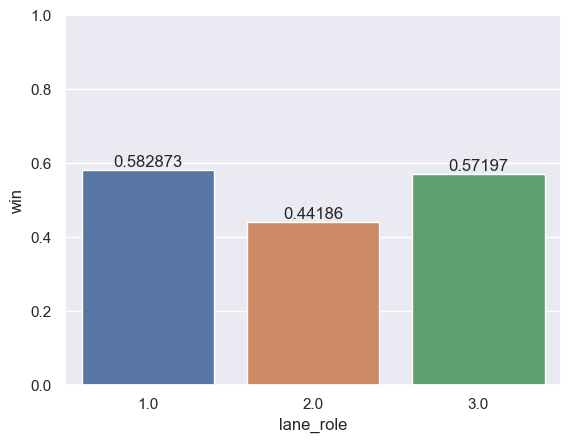

In [7]:
df_roles = df_matchplayers.loc[df_matchplayers["player_id"] == grubby_id] 
df_roles = df_roles[['win', 'lane_role']].groupby('lane_role').mean().reset_index()
df_roles
ax = sns.set_theme(style="darkgrid")
ax = sns.set_color_codes("colorblind")
ax = sns.barplot(x="lane_role", y="win", data=df_roles, label="Total")
ax.set_ylim(0, 1)
for i in ax.containers:
    ax.bar_label(i,)

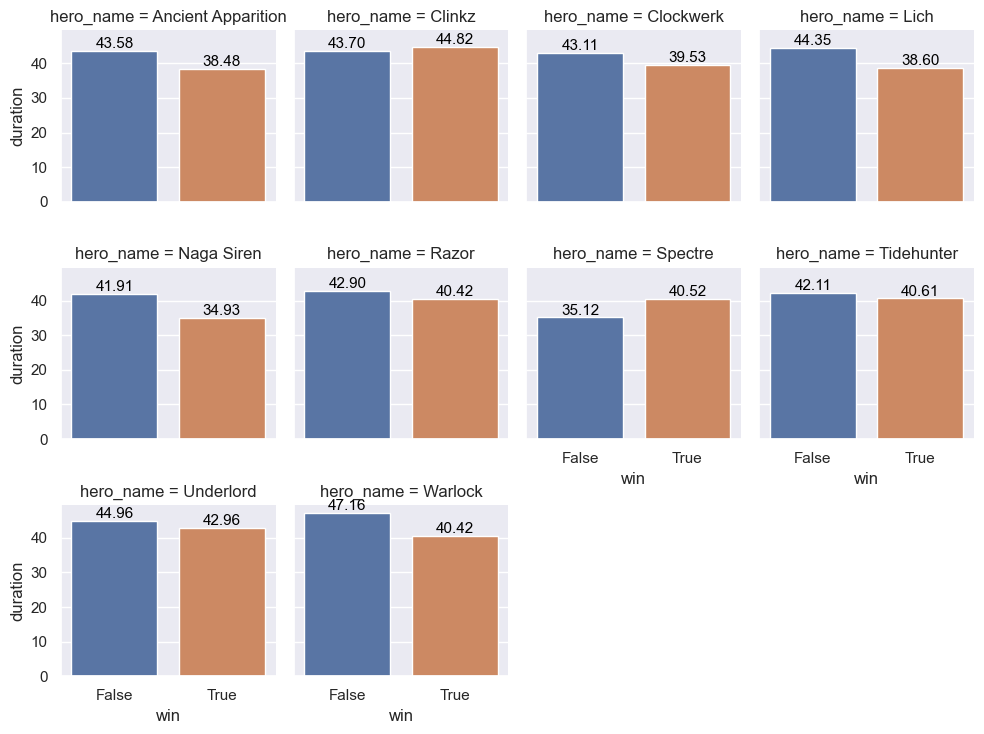

In [8]:
df_duration = df_grubby_matchplayers[['win', 'duration', 'hero_name']].groupby(['win', 'hero_name']).mean().reset_index()
df_duration = df_duration.loc[df_duration['hero_name'].isin(most_played)].sort_values('hero_name')

g = sns.catplot(x="win", y="duration", col='hero_name', col_wrap=4,
                data=df_duration,
                kind="bar", height=2.5, aspect=1, legend=True, legend_out=True)

for ax in g.axes:
    for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                 textcoords='offset points')


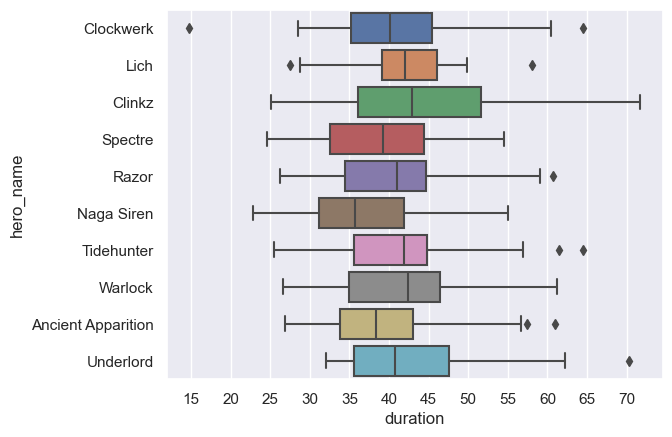

In [9]:
df_duration = df_grubby_matchplayers[['win', 'duration', 'hero_name']].loc[df_grubby_matchplayers['hero_name'].isin(most_played)]
df_duration

ax = sns.boxplot( y=df_duration["hero_name"], x=df_duration['duration'], orient='h' );
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))

In [10]:
df_first_games = df_grubby_matchplayers[['win', 'hero_name', 'start_time', 'duration']].sort_values('start_time', ascending=True).drop_duplicates(keep='first', subset='hero_name')
first_game_rate = df_first_games[['hero_name', 'win', 'duration']].sort_values('hero_name').mean()
ranked_heroes = df_first_games[['hero_name']].count()

win_rate = df_grubby_matchplayers[['win', 'duration']].mean()

total_played = df_grubby_matchplayers['duration'].div(60).sum()

print(win_rate)
print(first_game_rate)
print(ranked_heroes)
print(total_played)

win          0.569300
duration    41.961749
dtype: float64
win          0.593750
duration    44.833073
dtype: float64
hero_name    64
dtype: int64
469.27222222222224


In [1]:
hero = 'ursa'

df_avg_nw = df_matchplayers[['gold', 'hero_name']].groupby('hero_name').mean().reset_index()
print(df_avg_nw.loc[df_avg_nw['hero_name'] == hero])

NameError: name 'df_matchplayers' is not defined